In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shap
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import r2_score as R2, mean_absolute_error as MAE, mean_squared_error as MSE, accuracy_score as acs

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
pwd = os.getcwd()

In [3]:
df = pd.read_csv(pwd+"/Encoded_dataset/df_encoded_PCE.csv",low_memory=False)
df.shape

(26457, 30)

In [4]:
df.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure,JV_default_PCE
0,12.809252,0,0,12.609307,12.026303,370.0,13.592894,0,0,1,...,12.385423,12.247283,0,13.136545,148.0,12.521430,13.046064,80.0,12.675014,11.60
1,12.009877,0,0,12.571570,13.768498,279.6,12.357960,0,0,1,...,13.963644,14.258854,0,14.255519,34.0,12.521430,12.431390,100.0,12.675014,18.20
2,12.809252,0,0,12.609307,12.113869,480.0,12.879183,0,0,1,...,9.911379,9.447088,0,9.837867,218.0,11.874105,13.046064,50.0,12.675014,4.60
3,12.809252,0,0,12.571570,12.715600,279.6,12.572449,0,0,1,...,12.848716,12.488134,0,13.136545,34.0,12.521430,12.431390,100.0,12.675014,14.19
4,12.809252,0,0,12.609307,12.113869,230.0,12.879183,1,0,0,...,7.410069,10.896159,0,13.136545,20.0,12.521430,13.046064,80.0,12.675014,6.52


In [5]:
# Select feature list and target variable
X = df.iloc[:,:-1]
y = df['JV_default_PCE']  
print(f"Shape of X: {str(X.shape)}\nShape of y: {str(y.shape)}")

Shape of X: (26457, 29)
Shape of y: (26457,)


#### Loading new sample cell dataframe for prediction

In [6]:
new_X = pd.read_csv(pwd+"/Cell_to_predict/cell_encoded_PCE.csv")
new_X

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,12.809252,0,0,12.609307,12.7156,40.0,12.572449,0,0,1,...,0,12.541548,12.541548,0,9.837867,20.0,12.52143,12.43139,100.0,12.675014


## Scaling Features

In [7]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
new_X[new_X.columns] = scaler.transform(new_X[new_X.columns])

In [8]:
X.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,1.000000,0.0,0.0,0.843821,0.522545,0.014780,0.598900,0.0,0.0,1.0,...,0.0,0.466852,0.376360,0.0,0.602925,0.00588,0.651429,0.601206,0.000650,0.88095
1,0.857278,0.0,0.0,0.836302,0.668027,0.011164,0.471056,0.0,0.0,1.0,...,1.0,0.614941,0.586726,0.0,0.709951,0.00132,0.651429,0.528794,0.000817,0.88095
2,1.000000,0.0,0.0,0.843821,0.529857,0.019180,0.525014,0.0,0.0,1.0,...,0.0,0.234705,0.083522,0.0,0.287417,0.00868,0.561028,0.601206,0.000400,0.88095
3,1.000000,0.0,0.0,0.836302,0.580104,0.011164,0.493260,0.0,0.0,1.0,...,1.0,0.510324,0.401548,0.0,0.602925,0.00132,0.651429,0.528794,0.000817,0.88095
4,1.000000,0.0,0.0,0.843821,0.529857,0.009180,0.525014,1.0,0.0,0.0,...,0.0,0.000000,0.235062,0.0,0.602925,0.00076,0.651429,0.601206,0.000650,0.88095


In [9]:
new_X.head()

,Cell_architecture,Cell_flexible,Cell_semitransparent,Substrate_stack_sequence,ETL_stack_sequence,ETL_thickness,ETL_deposition_procedure,Perovskite_dimension_2D,Perovskite_dimension_2D3D_mixture,Perovskite_dimension_3D,...,Perovskite_deposition_quenching_induced_crystallisation,Perovskite_deposition_thermal_annealing_temperature,Perovskite_deposition_thermal_annealing_time,Perovskite_deposition_solvent_annealing,HTL_stack_sequence,HTL_thickness_list,HTL_deposition_procedure,Backcontact_stack_sequence,Backcontact_thickness_list,Backcontact_deposition_procedure
0,1.0,0.0,0.0,0.843821,0.580104,0.00158,0.49326,0.0,0.0,1.0,...,0.0,0.481502,0.407134,0.0,0.287417,0.00076,0.651429,0.528794,0.000817,0.88095


In [10]:
X_train, X_test, y_train, y_test = TTS(X,y,test_size=0.3,random_state=42)
print(f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

X_train: (18519, 29) 
X_test: (7938, 29) 
y_train: (18519,) 
y_test: (7938,)


In [11]:
def parity_plot(predicted_train, predicted_test, y1=y_train, y2=y_test):
    """ Plots the Predicted PCE vs Actual PCE"""
    plt.style.use('default')
    plt.figure(figsize=(5,5))
    plt.scatter(y1, predicted_train, c='r', label='Training data', edgecolors=(0, 0, 0), marker="o",s=100)
    plt.scatter(y2, predicted_test, c='b',label='Test data', edgecolors=(0, 0, 0), marker="o",s=100)
    plt.plot([-1.0, 26.0], [-1.0, 26.0],'k--', lw=2)
    plt.xlim(-1.0, 26.0)
    plt.ylim(-1.0, 26.0)
    plt.xlabel('Actual PCE (%)')
    plt.ylabel('Predicted PCE (%)')
    plt.legend(loc='upper left')
    
    plt.savefig(pwd+'/Parity_plots_RF/parity_plot_pce.png', dpi=600)
    return plt.show()

def get_evaluation(train_pred_y,test_pred_y):
    """ Gets ML model metrics Mean Square Error, Root Mean Square Error, Mean Absolute Error and R2 Score """
    # Metrics for Training Dataset
    mse_train = MSE(y_train, train_pred_y)
    rmse_train = np.sqrt(mse_train)
    mae_train = MAE(y_train, train_pred_y)
    r2_train = R2(y_train,train_pred_y)
   
    # Metrics for Test Dataset
    mse_test = MSE(y_test, test_pred_y)
    rmse_test = np.sqrt(mse_test)
    mae_test = MAE(y_test, test_pred_y)
    r2_test = R2(y_test,test_pred_y)

    eval_df = pd.DataFrame({
        "Metrics":["Mean Square Error (MSE)","Root Mean Square Error (RMSE)","Mean Absolute Error (MAE)","R2_Score"],
        "Training Data": [mse_train,rmse_train,mae_train,r2_train],
        "Test Data": [mse_test,rmse_test,mae_test,r2_test]
    })
    return eval_df

def model_builder(model_name):
    model_name.fit(X_train, y_train)
    y_pred_train = model_name.predict(X_train)
    y_pred_test = model_name.predict(X_test)
    parity_plot(y_pred_train,y_pred_test)
    eval_df = get_evaluation(y_pred_train,y_pred_test)
    return eval_df

### RandomForestRegressor Model

In [12]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt', 'log2', None]  
}

# Define the search object
search = RandomizedSearchCV(rf, param_grid, cv=5, n_iter=50, n_jobs=-1, random_state=42)

# Fit the search object to the training data
search.fit(X_train, y_train)

# Print the best parameters
print(f'Best parameters: {search.best_params_}')

# Get the best model
best_rf = search.best_estimator_

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


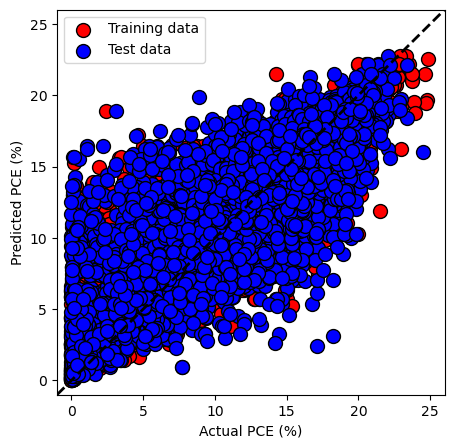

,Metrics,Training Data,Test Data
0,Mean Square Error (MSE),3.353819,7.879784
1,Root Mean Square Error (RMSE),1.831344,2.807095
2,Mean Absolute Error (MAE),1.218133,1.979787
3,R2_Score,0.875190,0.705092


In [13]:
best_rf_metrics = model_builder(best_rf)
best_rf_metrics

In [14]:
pickle.dump(best_rf, open(pwd + '/Hp_tuned_best_models/best_rf_PCE.sav', 'wb'))

In [15]:
predicted_PCE_rf = best_rf.predict(new_X)
predicted_PCE_rf

array([5.72215198])

### Feature Importances

In [16]:
features = X.columns
importances = best_rf.feature_importances_

In [17]:
imp_df = pd.DataFrame({"Features": features, "Importance": importances})
imp_df_sorted = imp_df.sort_values(by=["Importance"])
imp_df_sorted

,Features,Importance
16,Perovskite_band_gap_graded,0.000050
10,Perovskite_dimension_3D_with_2D_capping_layer,0.000374
8,Perovskite_dimension_2D3D_mixture,0.001168
22,Perovskite_deposition_solvent_annealing,0.002421
1,Cell_flexible,0.002625
7,Perovskite_dimension_2D,0.003528
2,Cell_semitransparent,0.003566
11,Perovskite_composition_perovskite_ABC3_structure,0.004985
9,Perovskite_dimension_3D,0.005364
14,Perovskite_composition_inorganic,0.007861


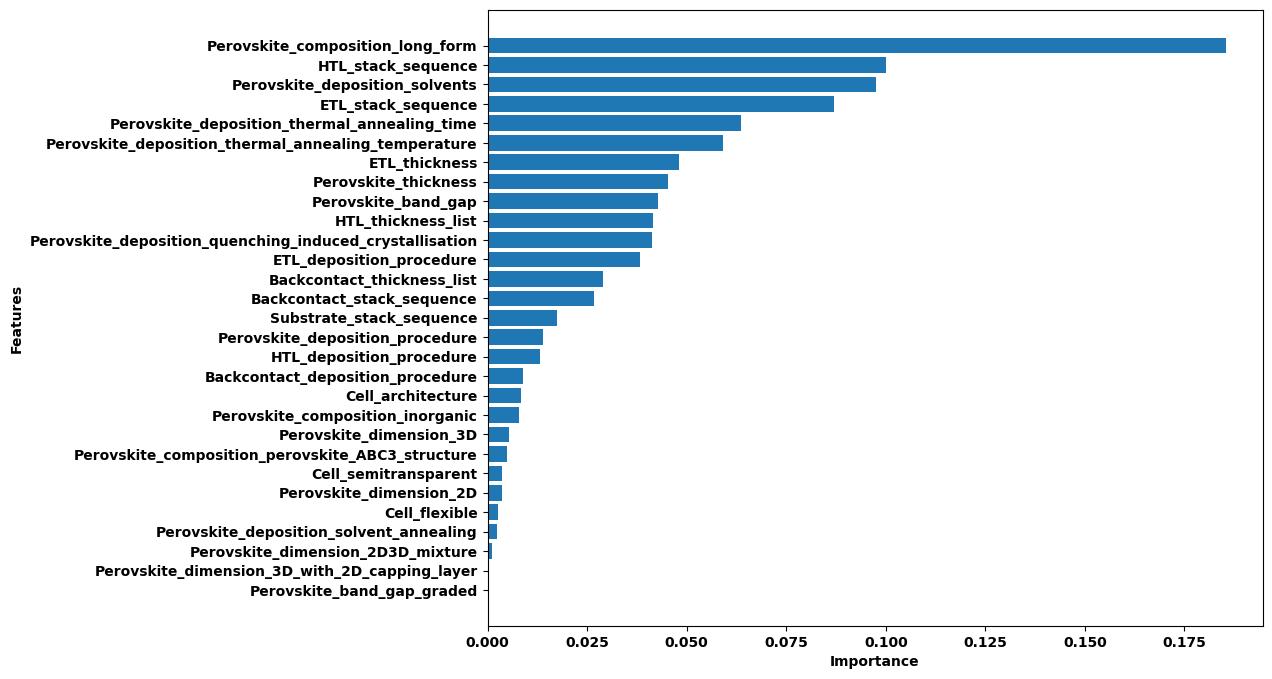

In [18]:
fig = plt.figure(figsize=(10,8))
plt.rcParams['font.weight']='bold'
plt.barh(imp_df_sorted["Features"],imp_df_sorted["Importance"])
plt.xlabel("Importance",weight='bold')
plt.ylabel("Features",weight='bold')
plt.savefig(pwd+"/Feature_Importances_Plots/RF_FI_PCE.png", bbox_inches='tight', dpi=600)
plt.show()

### Shap Analysis

In [18]:
explainer = shap.TreeExplainer(best_rf, X_test)
shap_values = explainer.shap_values(X_test, check_additivity=False)

100%|===================| 7930/7938 [15:01<00:00]        

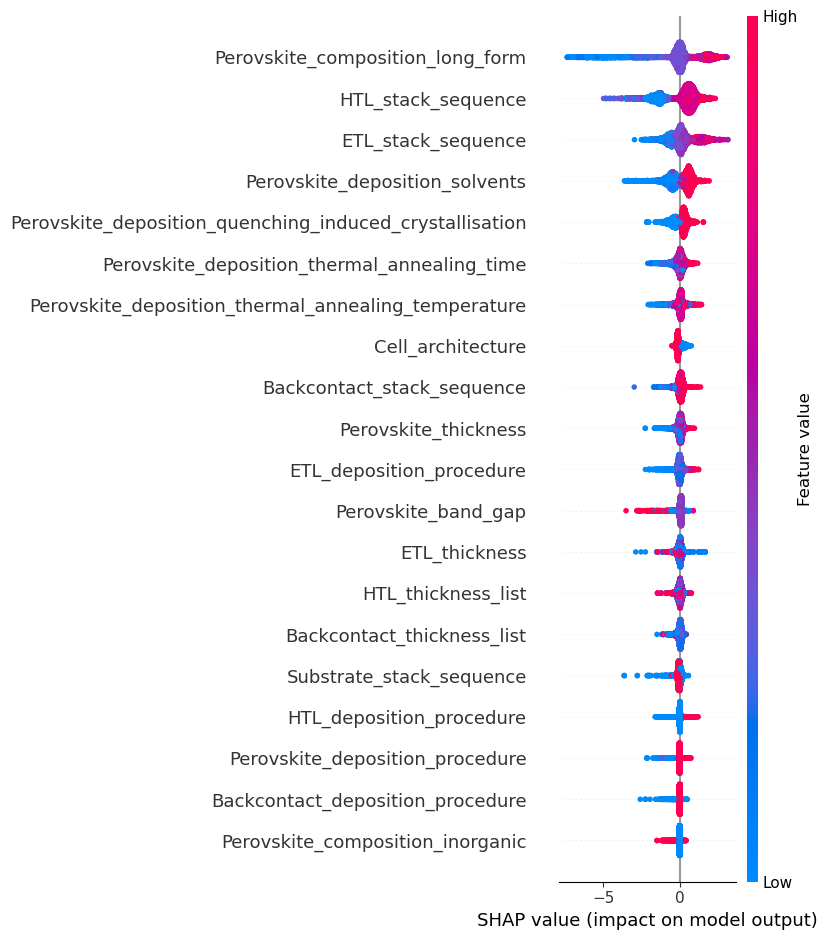

In [19]:
shap_fig = plt.figure()
shap.summary_plot(shap_values, X_test)
shap_fig.savefig(pwd+"/Feature_Importances_Plots/rf_shap_pce.png", bbox_inches='tight', dpi=500)